In [1]:
%%configure -f
{"driverMemory": "6000M"}

In [2]:
import hail as hl
hl.init(sc)

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2-amzn-0
SparkUI available at
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.80-4ccfae1ff293
LOGGING: writing to 

In [3]:
validation_15x_uri= "SG10K-SV-Release-1.4-15x-validation.mt"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
mt = hl.read_matrix_table(validation_15x_uri)

mt.describe()
mt.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    '_old_sv_id': str
    'qual': float64
    'filters': set<str>
    'callers_info': struct {
        manta: struct {
            ABHet: float64, 
            ABHom: float64, 
            ABHetMulti: array<float64>, 
            ABHomMulti: array<float64>, 
            AC: array<int32>, 
            AF: array<float64>, 
            AN: int32, 
            CR: int32, 
            END: int32, 
            HOMSEQ: array<str>, 
            INV3: bool, 
            INV5: bool, 
            LEFT_SVINSSEQ: array<str>, 
            LOGF: float64, 
            MaxAAS: array<int32>, 
            MaxAASR: array<float64>, 
            MaxAltPP: int32, 
            MQ: int32, 
            MQsquared: int32, 
            NCLUSTERS: int32, 
            NGT: array<i

In [5]:
# add metadata
release14_sample_metadata_uri = "2021_06_18_supplier_metadata.n10714_replacespace.txt"

### import metadata
t = hl.import_table(release14_sample_metadata_uri, delimiter="\t", quote="\"", impute=True)
#t.describe()

## annotate the hail mt with metadata
t = t.rename({"NPM_Research_ID" : "s"})
t = t.key_by(t.s)
mt = mt.annotate_cols(metadata = t[mt.s])
mt.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [6]:
%%sh
pip install boto3

In [7]:
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns

def save_fig_to_s3(fig, bucket, key):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='svg', dpi=300)
    img_data.seek(0)

    s3 = boto3.client('s3')
    response = s3.put_object(Bucket=bucket, Key=key, Body=img_data, ContentType='image/svg')
    print(response)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
import pandas as pd

_mt = (mt
        .group_rows_by(mt.callers_info.SVTYPE)
        .aggregate(
            sv_count = hl.agg.count_where(mt.GT.is_hom_var()) + hl.agg.count_where(mt.GT.is_het())
        )
      )

df = (_mt
      .annotate_cols(ethnicity = _mt.metadata.Self_Reported_Ethnicity)
      .rename({"SVTYPE": "sv_type"})
      .drop('metadata')
      .entries()
      .to_pandas()
     )
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHH1000    Indian      1395
1        DEL  WHH1001    Indian      1356
2        DEL  WHH1002    Indian      1161
3        DEL  WHH1003    Indian      1442
4        DEL  WHH1004    Indian      1412
...      ...      ...       ...       ...
4564     INS   WHH995    Indian      1519
4565     INS   WHH996    Indian      1446
4566     INS   WHH997    Indian      1376
4567     INS   WHH998    Indian      1462
4568     INS   WHH999    Indian      1431

[4569 rows x 4 columns]
2024-09-02 10:27:17 Hail: WARN: entries(): Resulting entries table is sorted by '(row_key, col_key)'.
    To preserve row-major matrix table order, first unkey columns with 'key_cols_by()'
2024-09-02 10:27:27 Hail: INFO: Coerced sorted dataset
2024-09-02 10:27:27 Hail: INFO: Coerced dataset with out-of-order partitions.

In [9]:
# extract deletions
del_df = df[df['sv_type'] == "DEL"]
del_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHH1000    Indian      1395
1        DEL  WHH1001    Indian      1356
2        DEL  WHH1002    Indian      1161
3        DEL  WHH1003    Indian      1442
4        DEL  WHH1004    Indian      1412
...      ...      ...       ...       ...
1518     DEL   WHH995    Indian      1385
1519     DEL   WHH996    Indian      1104
1520     DEL   WHH997    Indian      1154
1521     DEL   WHH998    Indian      1209
1522     DEL   WHH999    Indian      1239

[1523 rows x 4 columns]

In [17]:
del_chinese = del_df[del_df.ethnicity == "Chinese"]
del_chinese

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
69       DEL  WHH1116   Chinese      1345
82       DEL  WHH1129   Chinese      1238
94       DEL  WHH1142   Chinese      1502
95       DEL  WHH1143   Chinese      1476
96       DEL  WHH1144   Chinese      1160
...      ...      ...       ...       ...
1031     DEL  WHH2399   Chinese      1243
1032     DEL  WHH2400   Chinese      1436
1033     DEL  WHH2401   Chinese      1431
1034     DEL  WHH2410   Chinese      1182
1353     DEL   WHH801   Chinese      1138

[663 rows x 4 columns]

In [20]:
del_Malay = del_df[del_df.ethnicity == "Malay"]
del_Malay

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
667      DEL  WHH1736     Malay      1151
668      DEL  WHH1737     Malay      1382
669      DEL  WHH1738     Malay      1564
670      DEL  WHH1739     Malay      1336
671      DEL  WHH1740     Malay      1472
...      ...      ...       ...       ...
970      DEL  WHH2335     Malay      1335
996      DEL  WHH2361     Malay      1377
997      DEL  WHH2362     Malay      1271
999      DEL  WHH2364     Malay      1321
1014     DEL  WHH2380     Malay      1221

[278 rows x 4 columns]

In [19]:
del_Indian = del_df[del_df.ethnicity == "Indian"]
del_Indian

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHH1000    Indian      1395
1        DEL  WHH1001    Indian      1356
2        DEL  WHH1002    Indian      1161
3        DEL  WHH1003    Indian      1442
4        DEL  WHH1004    Indian      1412
...      ...      ...       ...       ...
1518     DEL   WHH995    Indian      1385
1519     DEL   WHH996    Indian      1104
1520     DEL   WHH997    Indian      1154
1521     DEL   WHH998    Indian      1209
1522     DEL   WHH999    Indian      1239

[581 rows x 4 columns]

In [21]:
del_ethnic = del_df[del_df.ethnicity != "Others"]
del_ethnic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHH1000    Indian      1395
1        DEL  WHH1001    Indian      1356
2        DEL  WHH1002    Indian      1161
3        DEL  WHH1003    Indian      1442
4        DEL  WHH1004    Indian      1412
...      ...      ...       ...       ...
1518     DEL   WHH995    Indian      1385
1519     DEL   WHH996    Indian      1104
1520     DEL   WHH997    Indian      1154
1521     DEL   WHH998    Indian      1209
1522     DEL   WHH999    Indian      1239

[1522 rows x 4 columns]

In [22]:
del_all = del_ethnic[["sv_type", "s", 'ethnicity', 'sv_count']].copy()
del_all['ethnicity'] = 'All'
del_all

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
0        DEL  WHH1000       All      1395
1        DEL  WHH1001       All      1356
2        DEL  WHH1002       All      1161
3        DEL  WHH1003       All      1442
4        DEL  WHH1004       All      1412
...      ...      ...       ...       ...
1518     DEL   WHH995       All      1385
1519     DEL   WHH996       All      1104
1520     DEL   WHH997       All      1154
1521     DEL   WHH998       All      1209
1522     DEL   WHH999       All      1239

[1522 rows x 4 columns]

In [23]:
frames = [del_chinese, del_Indian, del_Malay, del_all]
del_table = pd.concat(frames)
del_table

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
69       DEL  WHH1116   Chinese      1345
82       DEL  WHH1129   Chinese      1238
94       DEL  WHH1142   Chinese      1502
95       DEL  WHH1143   Chinese      1476
96       DEL  WHH1144   Chinese      1160
...      ...      ...       ...       ...
1518     DEL   WHH995       All      1385
1519     DEL   WHH996       All      1104
1520     DEL   WHH997       All      1154
1521     DEL   WHH998       All      1209
1522     DEL   WHH999       All      1239

[3044 rows x 4 columns]

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,15)})
sns.set_theme(style='whitegrid')
ax = sns.violinplot(hue = "ethnicity",
                    y="sv_count",
                    x= "sv_type",
                    data=del_table,
                    palette = ['#D62628', '#9467BD','#2EA02B', '#A9A9A9'],
                      linewidth=2
)
ax.set_xlabel("Ethnicity",fontsize=20)
ax.set_ylabel("Number of SV",fontsize=20)
ax.tick_params(labelsize=20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

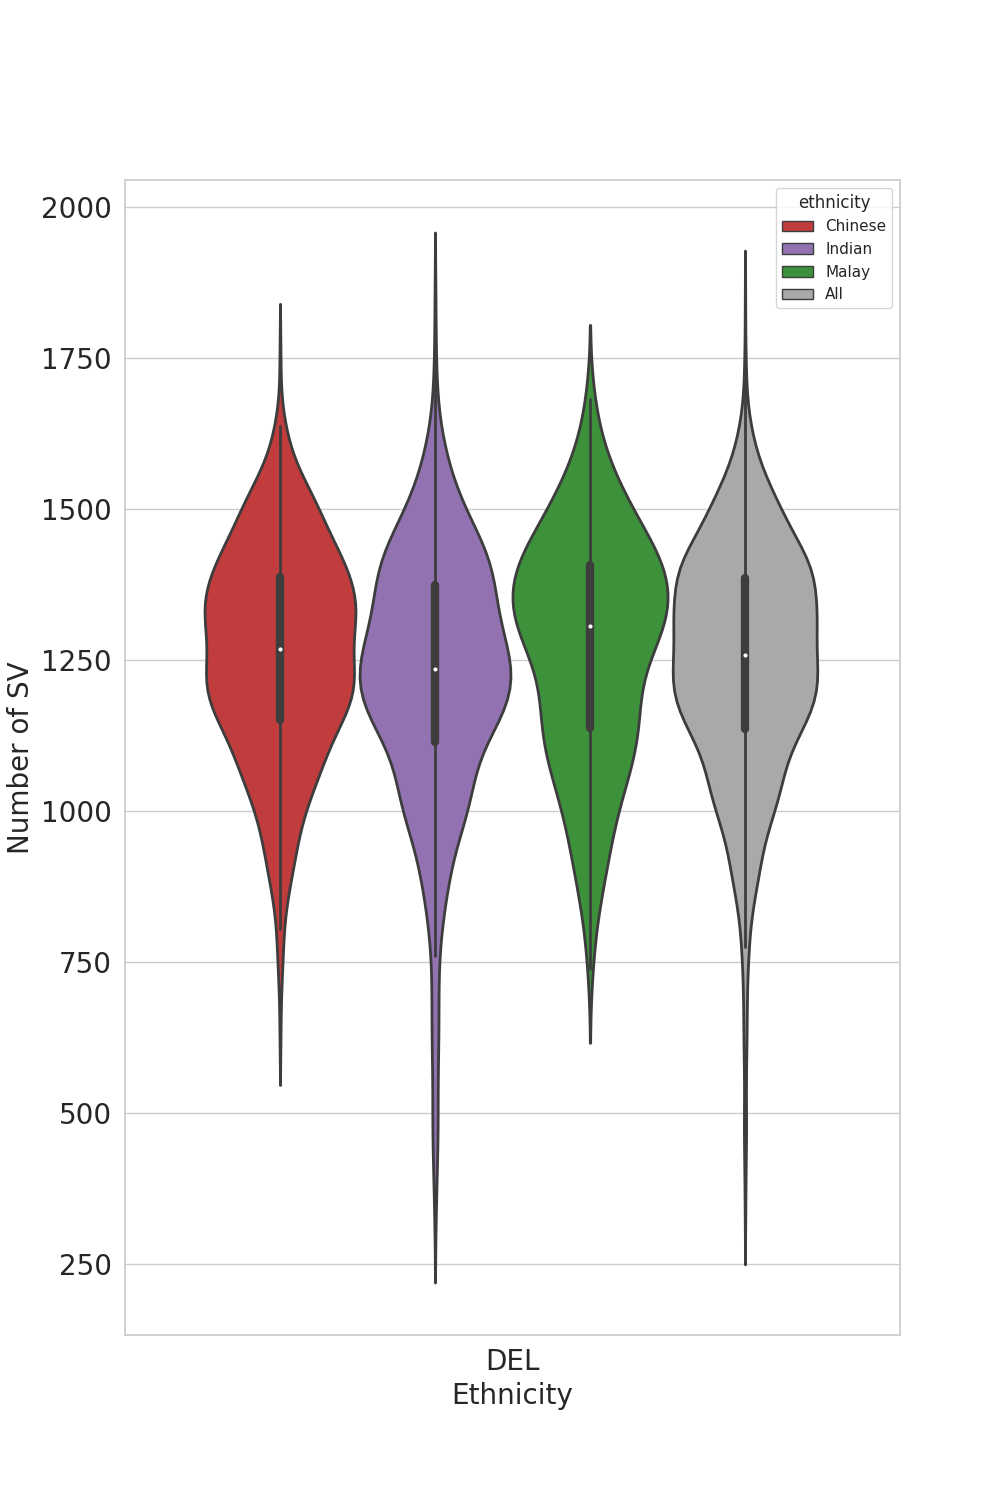

In [25]:
%matplot plt

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.clf()
plt.cla()
fig = plt.figure()
sns.set_theme(style='whitegrid')
ax = sns.violinplot(
                    y="sv_count",
                    x= "ethnicity",
                    data=del_table,
                    palette = ['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], inner=None, linewidth=0, saturation=0.5)

sns.boxplot(data=del_table, y="sv_count",x= "ethnicity",  saturation=0.5, width=0.4,
            palette=['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], boxprops={'zorder': 2}, ax=ax)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='ethnicity', ylabel='sv_count'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

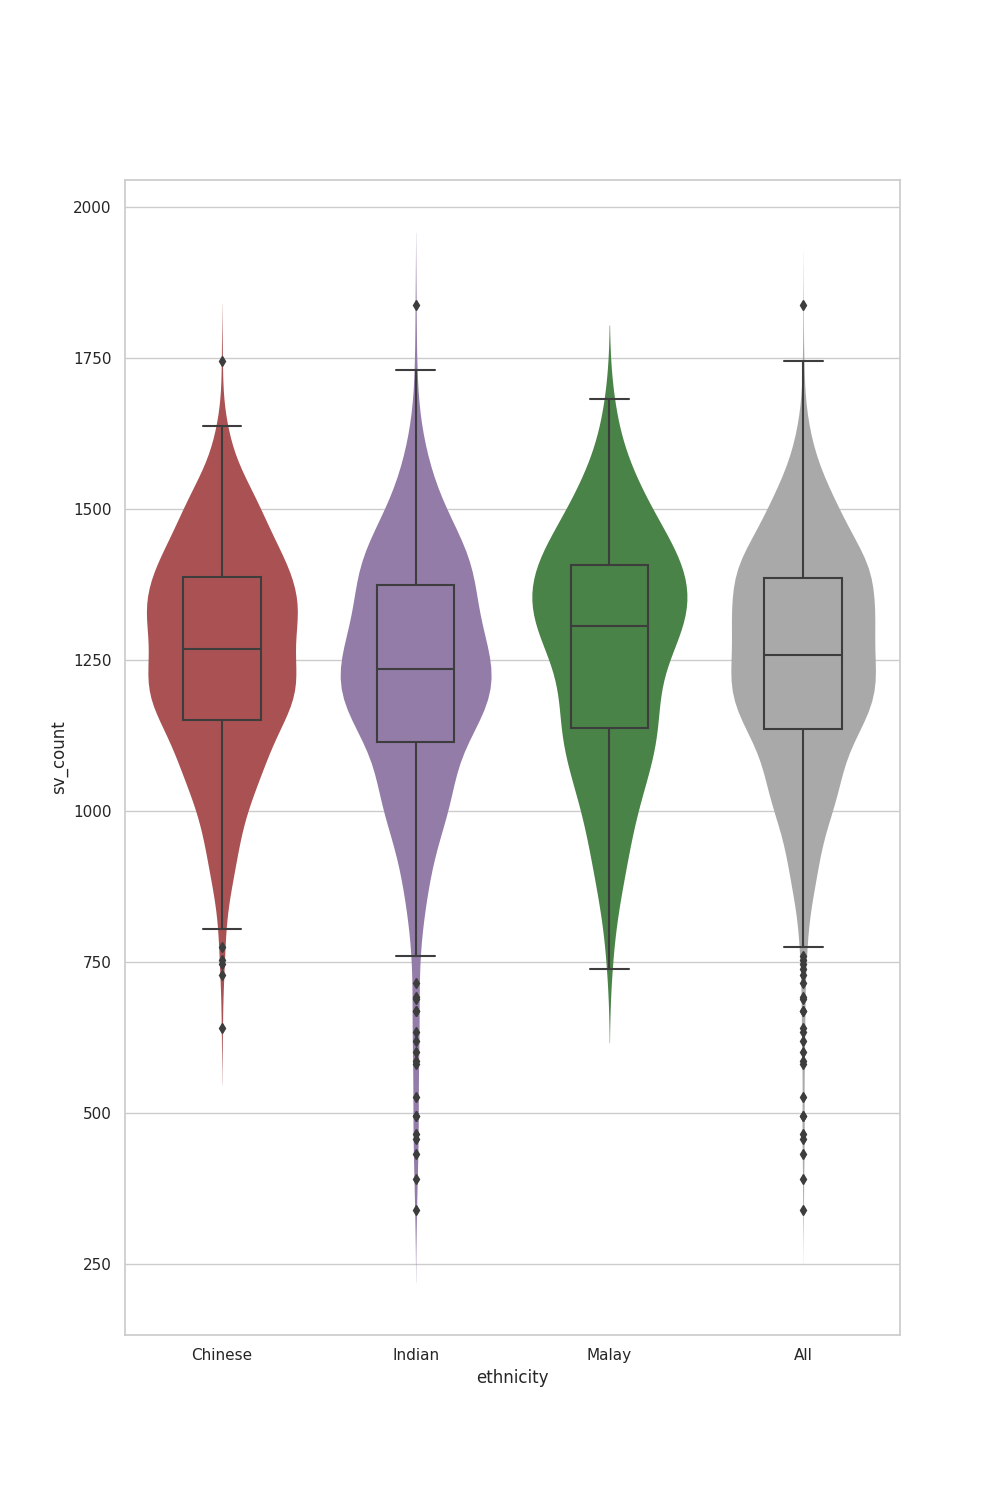

In [27]:
%matplot plt

In [28]:
save_fig_to_s3(plt, "Figures", "SupplementaryFig/15xvalidation_Numberofdeletionsperethnicgroup_withrectangleboxplot20240902.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Insertions

In [29]:
# extract insertions
ins_df = df[df['sv_type'] == "INS"]
ins_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3046     INS  WHH1000    Indian      1531
3047     INS  WHH1001    Indian      1472
3048     INS  WHH1002    Indian      1426
3049     INS  WHH1003    Indian      1591
3050     INS  WHH1004    Indian      1479
...      ...      ...       ...       ...
4564     INS   WHH995    Indian      1519
4565     INS   WHH996    Indian      1446
4566     INS   WHH997    Indian      1376
4567     INS   WHH998    Indian      1462
4568     INS   WHH999    Indian      1431

[1523 rows x 4 columns]

In [30]:
ins_chinese = ins_df[ins_df.ethnicity == "Chinese"]
ins_chinese

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3115     INS  WHH1116   Chinese      1424
3128     INS  WHH1129   Chinese      1413
3140     INS  WHH1142   Chinese      1508
3141     INS  WHH1143   Chinese      1461
3142     INS  WHH1144   Chinese      1351
...      ...      ...       ...       ...
4077     INS  WHH2399   Chinese      1440
4078     INS  WHH2400   Chinese      1508
4079     INS  WHH2401   Chinese      1529
4080     INS  WHH2410   Chinese      1398
4399     INS   WHH801   Chinese      1405

[663 rows x 4 columns]

In [31]:
ins_malay = ins_df[ins_df.ethnicity == "Malay"]
ins_malay

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3713     INS  WHH1736     Malay      1433
3714     INS  WHH1737     Malay      1518
3715     INS  WHH1738     Malay      1526
3716     INS  WHH1739     Malay      1539
3717     INS  WHH1740     Malay      1530
...      ...      ...       ...       ...
4016     INS  WHH2335     Malay      1485
4042     INS  WHH2361     Malay      1543
4043     INS  WHH2362     Malay      1482
4045     INS  WHH2364     Malay      1494
4060     INS  WHH2380     Malay      1417

[278 rows x 4 columns]

In [32]:
ins_indian = ins_df[ins_df.ethnicity == "Indian"]
ins_indian

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3046     INS  WHH1000    Indian      1531
3047     INS  WHH1001    Indian      1472
3048     INS  WHH1002    Indian      1426
3049     INS  WHH1003    Indian      1591
3050     INS  WHH1004    Indian      1479
...      ...      ...       ...       ...
4564     INS   WHH995    Indian      1519
4565     INS   WHH996    Indian      1446
4566     INS   WHH997    Indian      1376
4567     INS   WHH998    Indian      1462
4568     INS   WHH999    Indian      1431

[581 rows x 4 columns]

In [33]:
ins_ethnic = ins_df[ins_df.ethnicity != "Others"]
ins_ethnic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3046     INS  WHH1000    Indian      1531
3047     INS  WHH1001    Indian      1472
3048     INS  WHH1002    Indian      1426
3049     INS  WHH1003    Indian      1591
3050     INS  WHH1004    Indian      1479
...      ...      ...       ...       ...
4564     INS   WHH995    Indian      1519
4565     INS   WHH996    Indian      1446
4566     INS   WHH997    Indian      1376
4567     INS   WHH998    Indian      1462
4568     INS   WHH999    Indian      1431

[1522 rows x 4 columns]

In [34]:
ins_all = ins_ethnic[["sv_type", "s", 'ethnicity', 'sv_count']].copy()
ins_all['ethnicity'] = 'All'
ins_all

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3046     INS  WHH1000       All      1531
3047     INS  WHH1001       All      1472
3048     INS  WHH1002       All      1426
3049     INS  WHH1003       All      1591
3050     INS  WHH1004       All      1479
...      ...      ...       ...       ...
4564     INS   WHH995       All      1519
4565     INS   WHH996       All      1446
4566     INS   WHH997       All      1376
4567     INS   WHH998       All      1462
4568     INS   WHH999       All      1431

[1522 rows x 4 columns]

In [35]:
frames_ins = [ins_chinese, ins_indian, ins_malay, ins_all]
ins_table = pd.concat(frames_ins)
ins_table

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
3115     INS  WHH1116   Chinese      1424
3128     INS  WHH1129   Chinese      1413
3140     INS  WHH1142   Chinese      1508
3141     INS  WHH1143   Chinese      1461
3142     INS  WHH1144   Chinese      1351
...      ...      ...       ...       ...
4564     INS   WHH995       All      1519
4565     INS   WHH996       All      1446
4566     INS   WHH997       All      1376
4567     INS   WHH998       All      1462
4568     INS   WHH999       All      1431

[3044 rows x 4 columns]

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,15)})
sns.set_theme(style='whitegrid')
ax = sns.violinplot(hue = "ethnicity",
                    y="sv_count",
                    x= "sv_type",
                    data=ins_table,
                    palette = ['#D62628', '#9467BD', '#2EA02B','#A9A9A9'],linewidth=2)
ax.set_xlabel("Ethnicity",fontsize=20)
ax.set_ylabel("Number of SV",fontsize=20)
ax.tick_params(labelsize=20)
mean = ins_table.groupby("ethnicity")["sv_count"].mean()
print(mean)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ethnicity
All        1451.890276
Chinese    1442.764706
Indian     1455.018933
Malay      1467.115108
Name: sv_count, dtype: float64

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

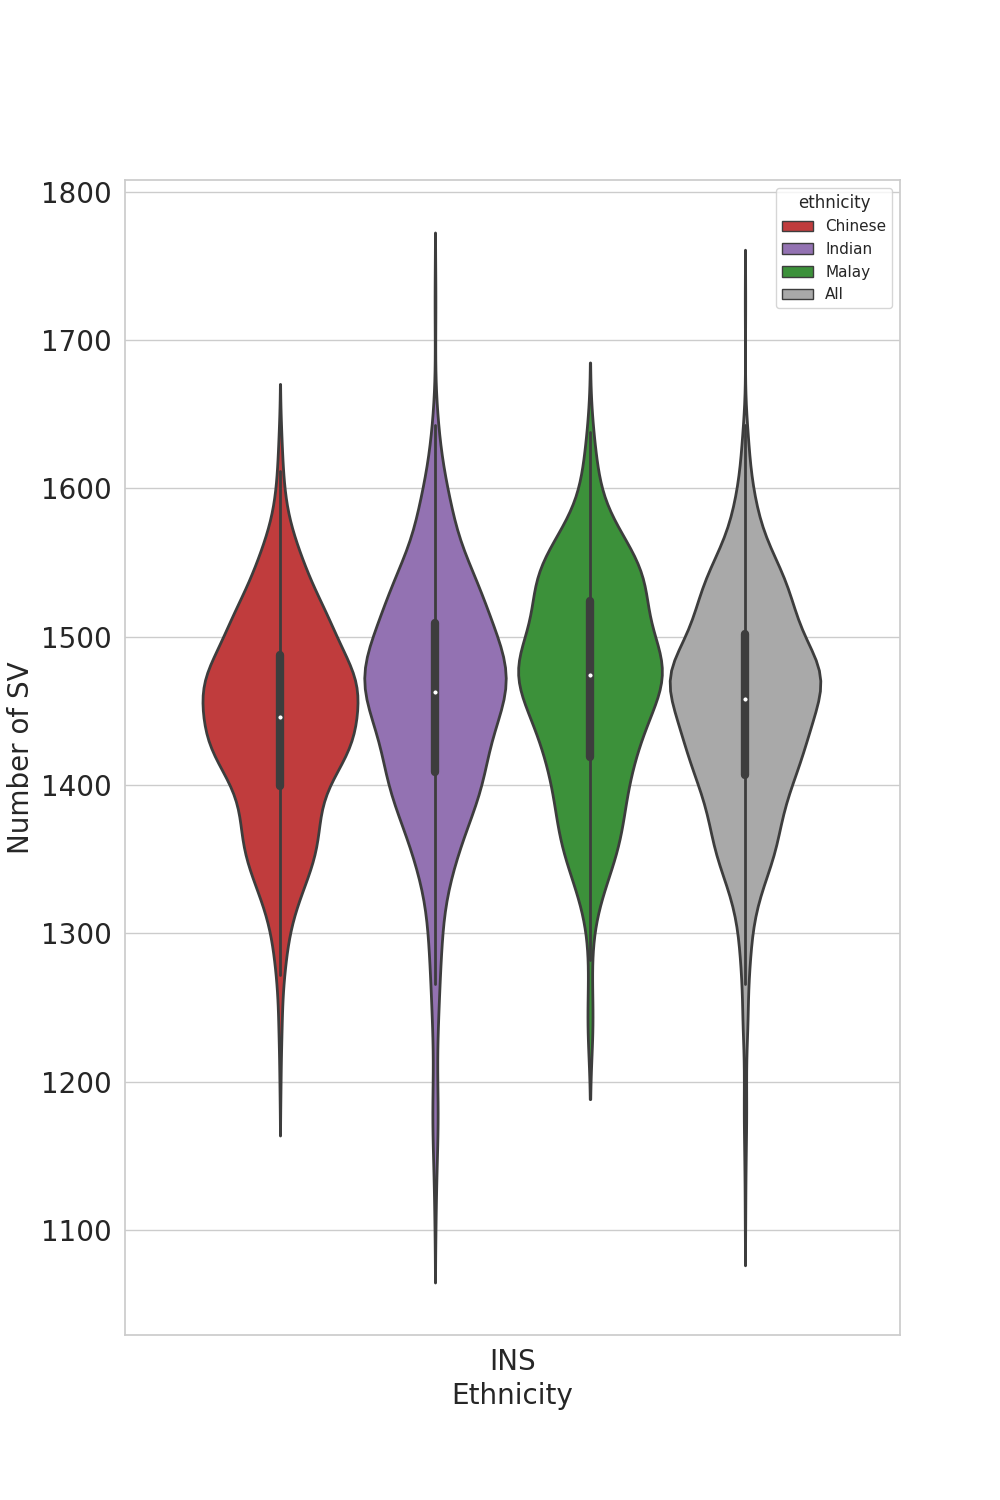

In [37]:
%matplot plt

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.clf()
plt.cla()
fig = plt.figure()
sns.set_theme(style='whitegrid')
ax = sns.violinplot(
                    y="sv_count",
                    x= "ethnicity",
                    data=ins_table,
                    palette = ['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], inner=None, linewidth=0, saturation=0.5)

sns.boxplot(data=ins_table, y="sv_count",x= "ethnicity",  saturation=0.5, width=0.4,
            palette=['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], boxprops={'zorder': 2}, ax=ax)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='ethnicity', ylabel='sv_count'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

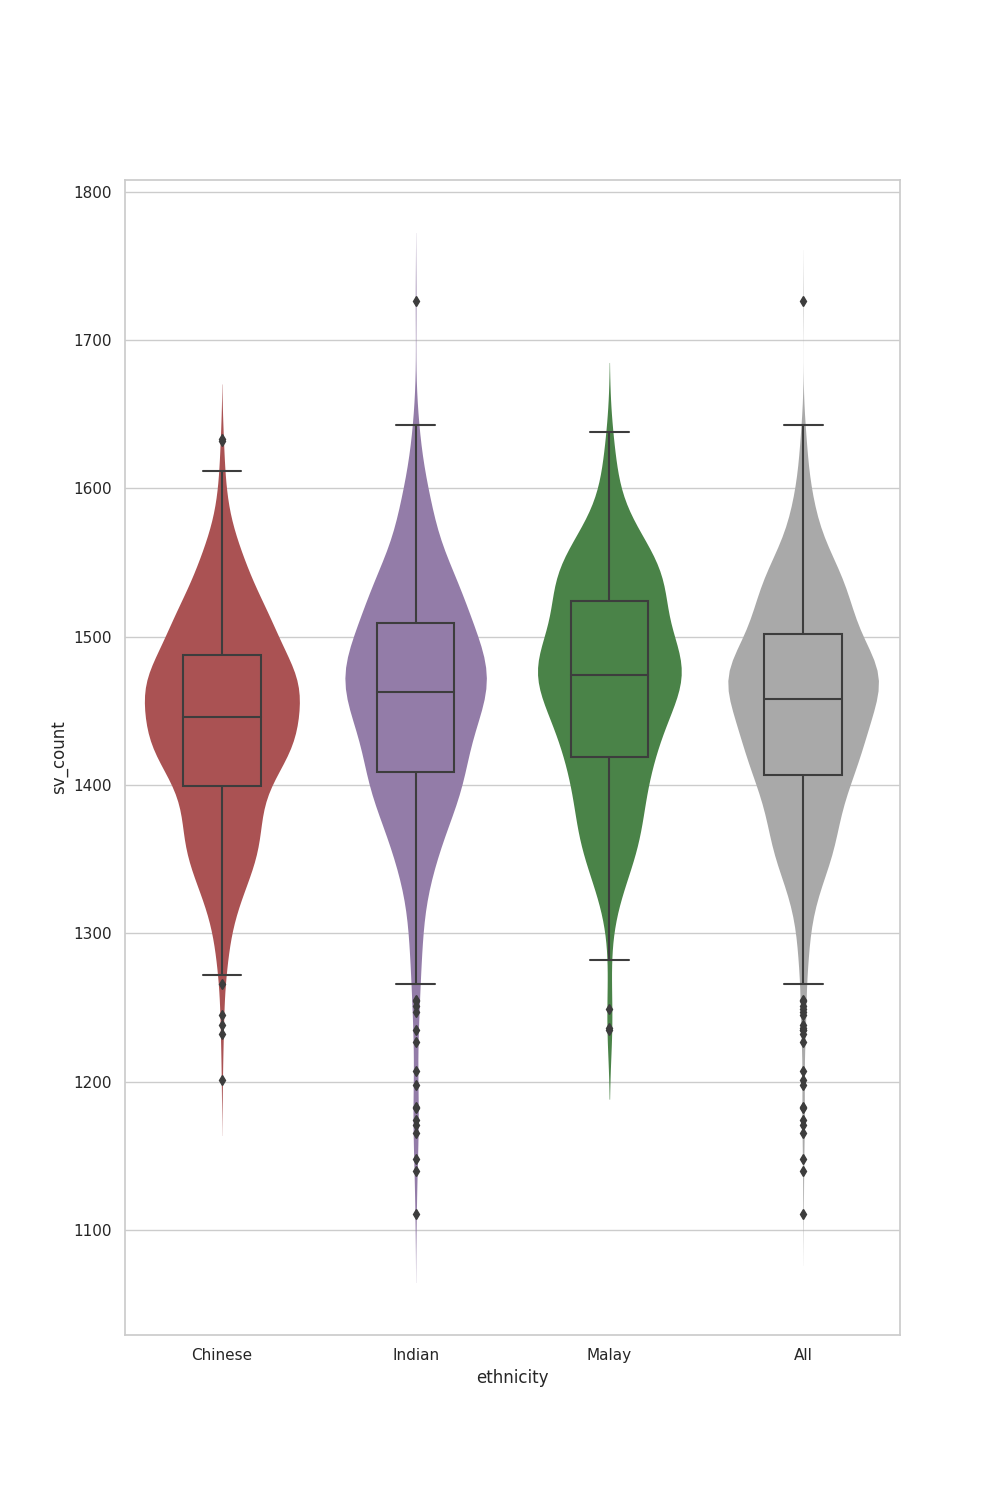

In [39]:
%matplot plt

In [40]:
save_fig_to_s3(plt, "Figures", "SupplementaryFig/15xValidation_NumberofInsertionsperethnicgroup_whitegrid_rectangleboxplot.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Duplications

In [41]:
# extract duplications
dup_df = df[df['sv_type'] == "DUP"]
dup_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
1523     DUP  WHH1000    Indian       672
1524     DUP  WHH1001    Indian       649
1525     DUP  WHH1002    Indian       598
1526     DUP  WHH1003    Indian       661
1527     DUP  WHH1004    Indian       644
...      ...      ...       ...       ...
3041     DUP   WHH995    Indian       660
3042     DUP   WHH996    Indian       571
3043     DUP   WHH997    Indian       604
3044     DUP   WHH998    Indian       573
3045     DUP   WHH999    Indian       602

[1523 rows x 4 columns]

In [42]:
dup_chinese = dup_df[dup_df.ethnicity == "Chinese"]
dup_chinese

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
1592     DUP  WHH1116   Chinese       704
1605     DUP  WHH1129   Chinese       646
1617     DUP  WHH1142   Chinese       650
1618     DUP  WHH1143   Chinese       700
1619     DUP  WHH1144   Chinese       615
...      ...      ...       ...       ...
2554     DUP  WHH2399   Chinese       711
2555     DUP  WHH2400   Chinese       689
2556     DUP  WHH2401   Chinese       729
2557     DUP  WHH2410   Chinese       683
2876     DUP   WHH801   Chinese       589

[663 rows x 4 columns]

In [43]:
dup_indian = dup_df[dup_df.ethnicity == "Indian"]
dup_indian

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
1523     DUP  WHH1000    Indian       672
1524     DUP  WHH1001    Indian       649
1525     DUP  WHH1002    Indian       598
1526     DUP  WHH1003    Indian       661
1527     DUP  WHH1004    Indian       644
...      ...      ...       ...       ...
3041     DUP   WHH995    Indian       660
3042     DUP   WHH996    Indian       571
3043     DUP   WHH997    Indian       604
3044     DUP   WHH998    Indian       573
3045     DUP   WHH999    Indian       602

[581 rows x 4 columns]

In [44]:
dup_malay = dup_df[dup_df.ethnicity == "Malay"]
dup_malay

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
2190     DUP  WHH1736     Malay       749
2191     DUP  WHH1737     Malay       820
2192     DUP  WHH1738     Malay       815
2193     DUP  WHH1739     Malay       746
2194     DUP  WHH1740     Malay       817
...      ...      ...       ...       ...
2493     DUP  WHH2335     Malay       716
2519     DUP  WHH2361     Malay       742
2520     DUP  WHH2362     Malay       692
2522     DUP  WHH2364     Malay       722
2537     DUP  WHH2380     Malay       710

[278 rows x 4 columns]

In [45]:
dup_ethnic = dup_df[dup_df.ethnicity != "Others"]
dup_ethnic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
1523     DUP  WHH1000    Indian       672
1524     DUP  WHH1001    Indian       649
1525     DUP  WHH1002    Indian       598
1526     DUP  WHH1003    Indian       661
1527     DUP  WHH1004    Indian       644
...      ...      ...       ...       ...
3041     DUP   WHH995    Indian       660
3042     DUP   WHH996    Indian       571
3043     DUP   WHH997    Indian       604
3044     DUP   WHH998    Indian       573
3045     DUP   WHH999    Indian       602

[1522 rows x 4 columns]

In [46]:
dup_all = dup_ethnic[["sv_type", "s", 'ethnicity', 'sv_count']].copy()
dup_all['ethnicity'] = 'All'
dup_all

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
1523     DUP  WHH1000       All       672
1524     DUP  WHH1001       All       649
1525     DUP  WHH1002       All       598
1526     DUP  WHH1003       All       661
1527     DUP  WHH1004       All       644
...      ...      ...       ...       ...
3041     DUP   WHH995       All       660
3042     DUP   WHH996       All       571
3043     DUP   WHH997       All       604
3044     DUP   WHH998       All       573
3045     DUP   WHH999       All       602

[1522 rows x 4 columns]

In [47]:
frames_dup = [dup_chinese, dup_indian, dup_malay, dup_all]
dup_table = pd.concat(frames_dup)
dup_table

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     sv_type        s ethnicity  sv_count
1592     DUP  WHH1116   Chinese       704
1605     DUP  WHH1129   Chinese       646
1617     DUP  WHH1142   Chinese       650
1618     DUP  WHH1143   Chinese       700
1619     DUP  WHH1144   Chinese       615
...      ...      ...       ...       ...
3041     DUP   WHH995       All       660
3042     DUP   WHH996       All       571
3043     DUP   WHH997       All       604
3044     DUP   WHH998       All       573
3045     DUP   WHH999       All       602

[3044 rows x 4 columns]

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,15)})
sns.set_theme(style='whitegrid')
ax = sns.violinplot(hue = "ethnicity",
                    y="sv_count",
                    x= "sv_type",
                    data=dup_table,
                    palette = ['#D62628', '#9467BD', '#2EA02B','#A9A9A9'], linewidth=2)
ax.set_xlabel("Ethnicity",fontsize=20)
ax.set_ylabel("Number of SV",fontsize=20)
ax.tick_params(labelsize=20)
mean = dup_table.groupby("ethnicity")["sv_count"].mean()
print(mean)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ethnicity
All        712.584757
Chinese    741.187029
Indian     657.165232
Malay      760.194245
Name: sv_count, dtype: float64

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

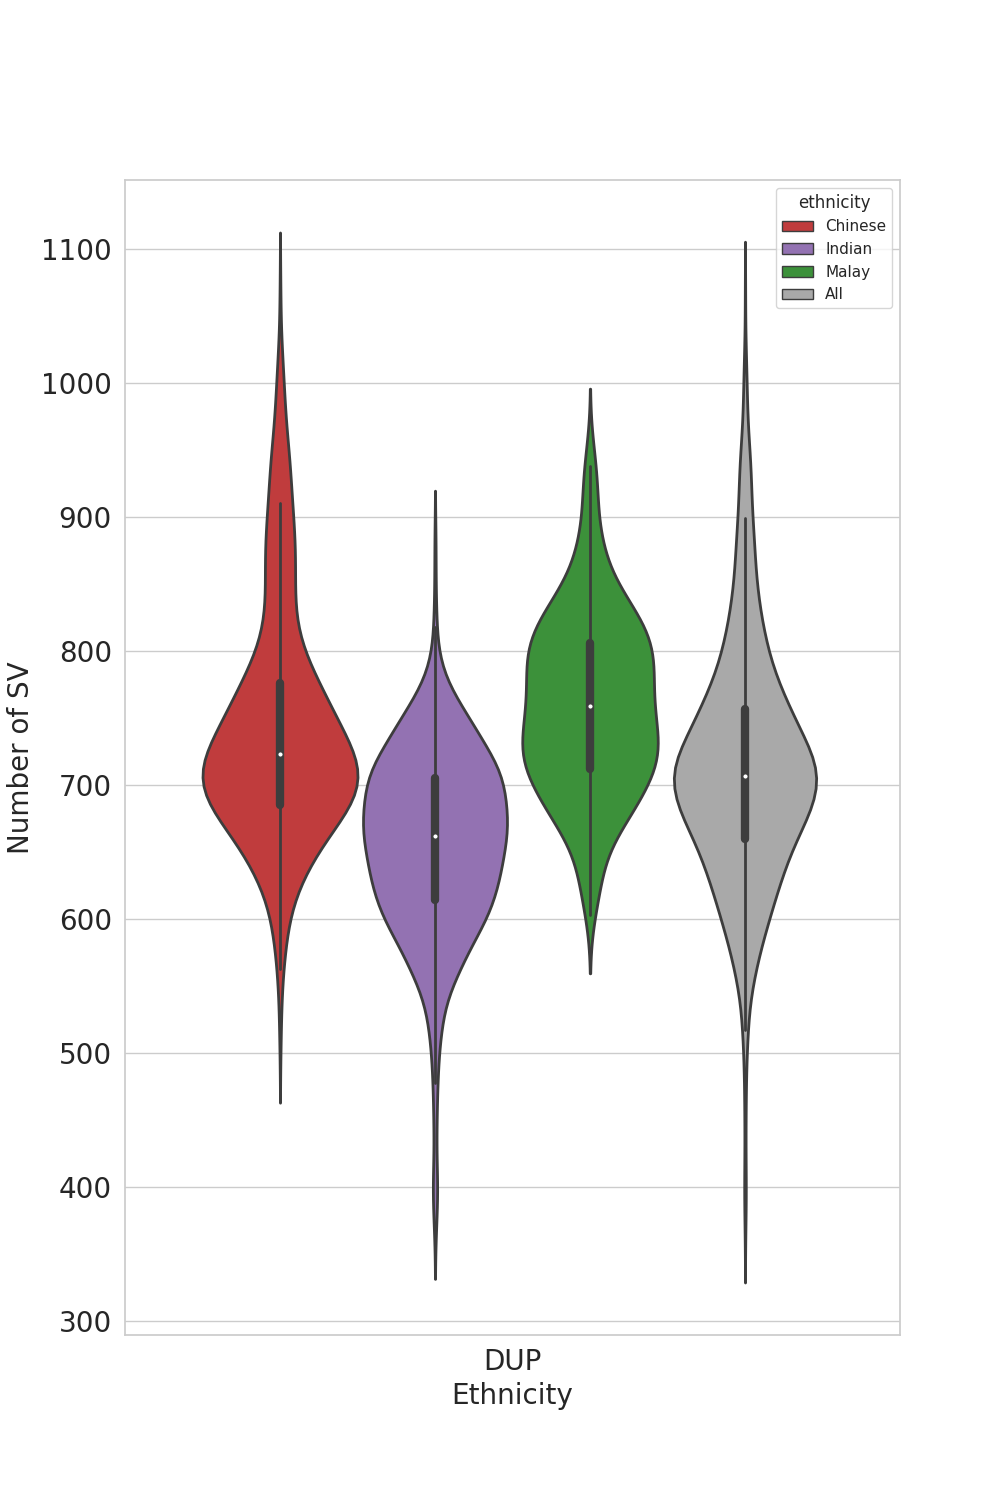

In [49]:
%matplot plt

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.clf()
plt.cla()
fig = plt.figure()
sns.set_theme(style='whitegrid')
ax = sns.violinplot(
                    y="sv_count",
                    x= "ethnicity",
                    data=dup_table,
                    palette = ['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], inner=None, linewidth=0, saturation=0.5)

sns.boxplot(data=dup_table, y="sv_count",x= "ethnicity",  saturation=0.5, width=0.4,
            palette=['#D62628', '#9467BD','#2EA02B', '#A9A9A9'], boxprops={'zorder': 2}, ax=ax)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='ethnicity', ylabel='sv_count'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

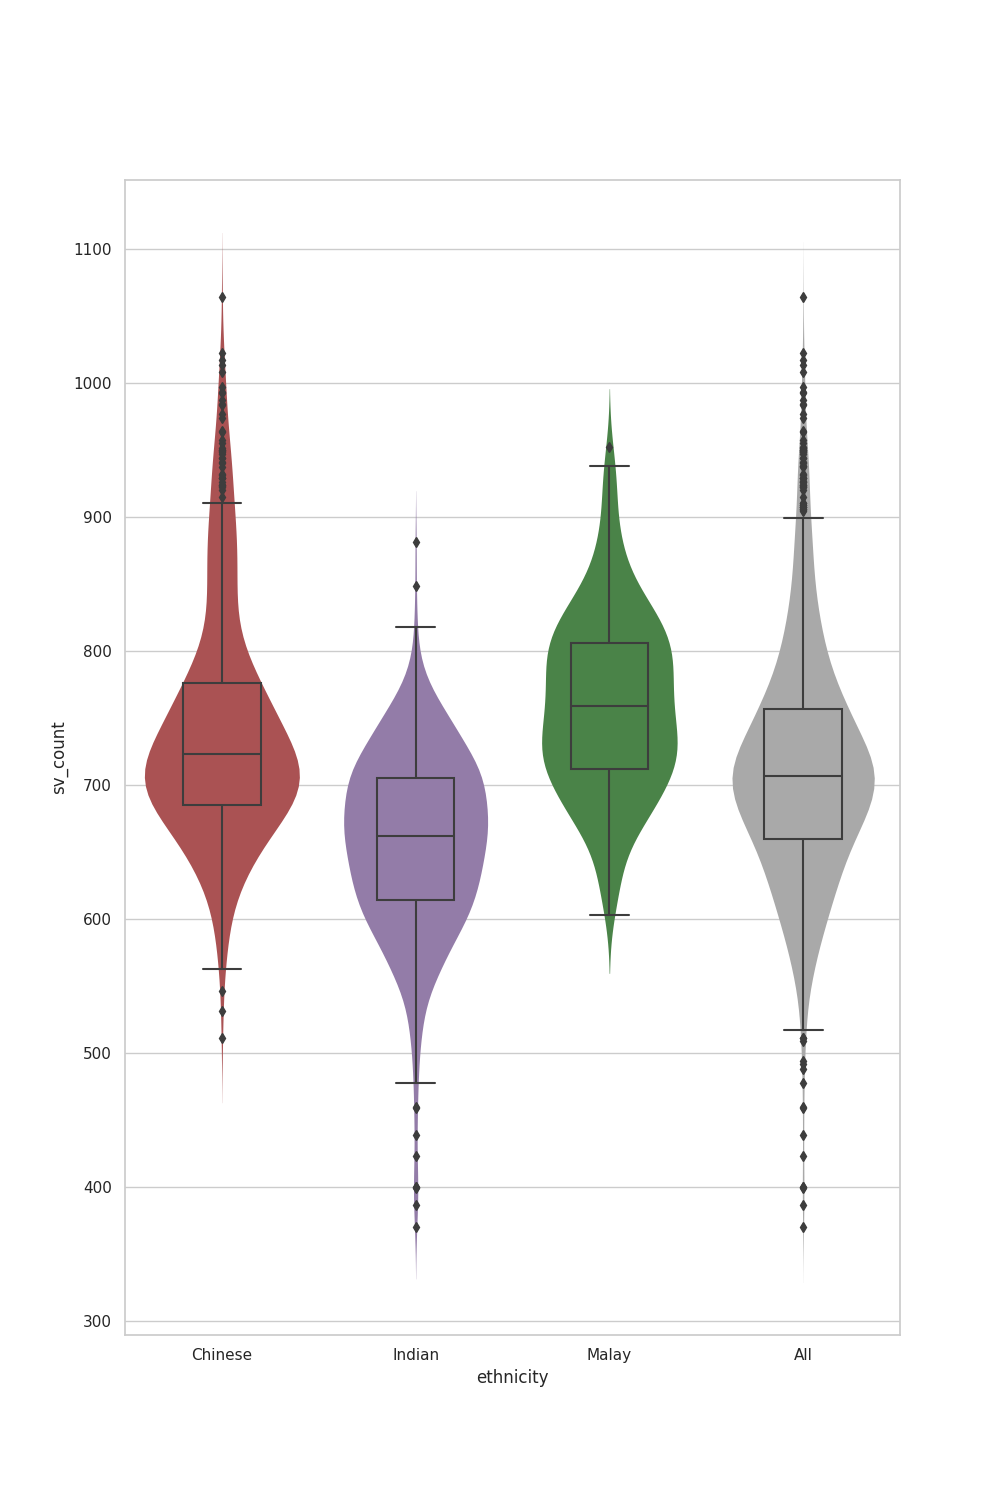

In [51]:
%matplot plt

In [52]:
save_fig_to_s3(plt, "Figures", "SupplementaryFig/15xValidation_NumberofDuplicationsperethnicgroup_whitegrid_rectangleboxplot.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…